# Projet de détection de tumeur cérébrale
## Classification binaire d'un jeu de données d'images d'IRM cérébraux
### Introduction
Ce notebook a pour objectif de construire et de comparer 2 réseaux de neurones (convolutionnel et perceptrons multi-couches) dans la classification binaire d'IRM cérébraux. 
L'entraînement, le test, et la validation de ces réseaux s'appuie sur la base de données suivantequi contient des IRM cérébraux associés à la présence ou l'absence de tumeur:
https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [2]:
# Nettoyage du répertoire de sortie
!rm -rf /kaggle/working/*

### Importation des bibliothèques

In [1]:
import tensorflow as tf
import random as rd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Chargement et pré-traitement des données

In [28]:
# Chargement des données

path_No = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/*'
path_Yes = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/*'

tumor = []
no_tumor = []

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)      # Lecture des images du dossier
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        # Changement de BGR vers RGB
    img = cv2.resize(img, (128, 128)) 
    tumor.append((img, 1))  # Ajout du tuple (image, label 1) indiquant la présence d'une tumeur

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  # Ajout du tuple (image, label 0) indiquant l'absence de tumeur

# Concaténation et mélange des données
all_data = tumor + no_tumor
rd.shuffle(all_data)

# Séparation des données et des labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

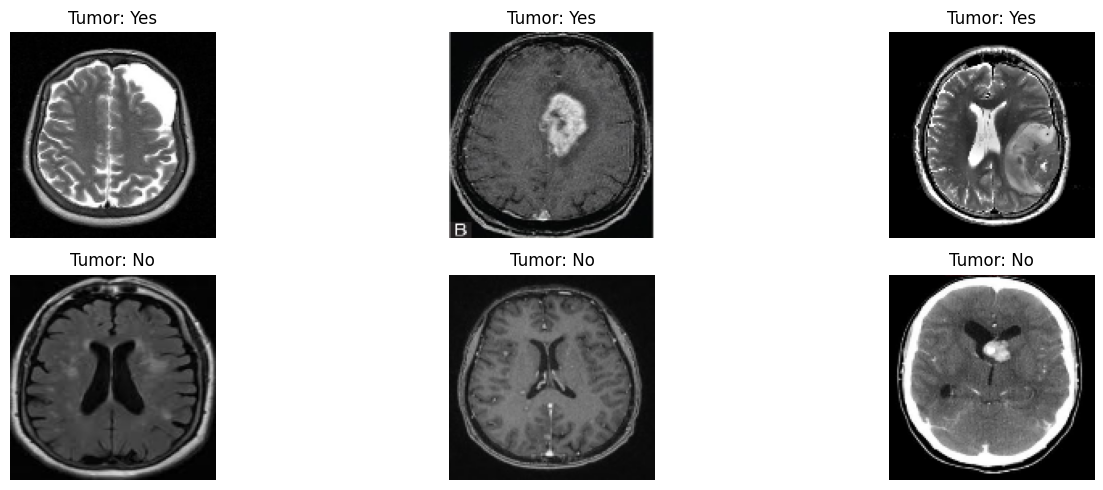

In [29]:
# Exploration des données

plt.figure(figsize=(15, 5))

# Affichage d'images avec tumeurs et le label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])  
    plt.title("Tumor: Yes")  
    plt.axis('off')

# Affichage d'images sans tumeur et le label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])  
    plt.title("Tumor: No")  
    plt.axis('off')

plt.tight_layout()
plt.show()

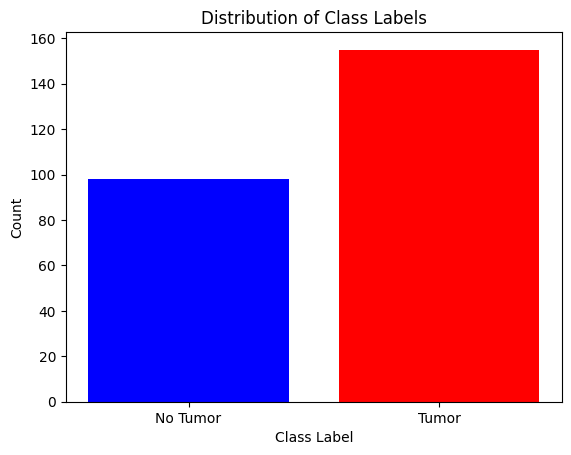

In [30]:
# Nombre d'occurences de chaque label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'red'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [31]:
# Séparation en jeu d'entraînement et jeu de test
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=0.20, random_state=42)

# Normalisation des données

train_images = train_images / 255.0
test_images = test_images / 255.0

### Construction et entraînement des modèles

In [94]:
# Construction du modèle MLP

def get_MLP_model():
    model = Sequential([
        Input(shape=(128,128,3), name='input_layer'),
        Flatten(name='flatten_layer'),
        Dense(64, activation='relu', name='dense_layer_1'),
        Dense(64, activation='relu', name='dense_layer_2'),
        Dense(1, activation='sigmoid', name='output_layer')
    ])

    return model

In [95]:
# Affichage de l'architecture

MLP_model = get_MLP_model()
MLP_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_layer (Flatten)              │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_1 (Dense)                │ (None, 64)                  │       3,145,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_2 (Dense)                │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,150,017 (12.02 MB)

 Trainable params: 3,150,017 (12.02 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# Compilation du modèle

MLP_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [97]:
# Création d'une sauvegarde des meilleurs poids

MLP_checkpoint = ModelCheckpoint(filepath='MLP_model_checkpoints_best/checkpoint.weights.h5',
                            save_weights_only = True,
                            save_freq='epoch',
                            monitor='val_acc',
                            save_best_only = True,
                            verbose=1)

In [98]:
# Entraînement du modèle MLP

mlp_history = MLP_model.fit(train_images, 
                    train_labels,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2,callbacks=[MLP_checkpoint])

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - acc: 0.5327 - loss: 1.9661
Epoch 1: val_acc improved from -inf to 0.29268, saving model to MLP_model_checkpoints_best/checkpoint.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - acc: 0.5393 - loss: 2.0745 - val_acc: 0.2927 - val_loss: 8.2734
Epoch 2/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.4375 - loss: 6.6940
Epoch 2: val_acc improved from 0.29268 to 0.70732, saving model to MLP_model_checkpoints_best/checkpoint.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - acc: 0.4497 - loss: 4.4340 - val_acc: 0.7073 - val_loss: 1.8725
Epoch 3/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.5781 - loss: 2.2104
Epoch 3: val_acc did not improve from 0.70732
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.5868 - loss: 2.1691 - val_acc: 0.7073 - val_loss: 0.8302
Epoch 4/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.7500 - loss: 0.5390
Epoch 4: val_acc did not improve from 0.70732
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.67

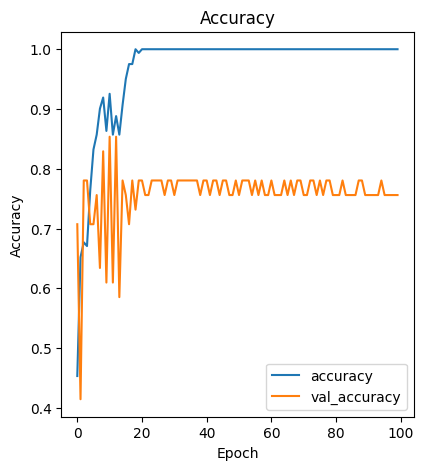

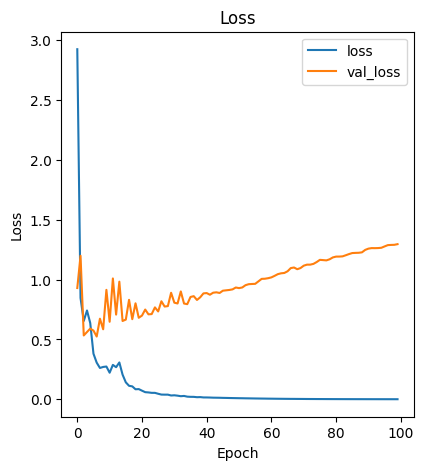

In [99]:
# Affichage de la précision et de la perte

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["acc"], label="accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [100]:
# Evaluation du modèle
test_loss, test_acc = MLP_model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - acc: 0.7598 - loss: 0.8318
Test Loss: 0.7810677289962769
Test Accuracy: 0.7647058963775635


In [101]:
# Evaluation du meilleur modèle

MLP_best_model = get_MLP_model()
MLP_best_model.load_weights('MLP_model_checkpoints_best/checkpoint.weights.h5')
MLP_best_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['acc'])
best_loss, best_acc = MLP_best_model.evaluate(test_images, test_labels, verbose=False)

print('Loss at best epoch : {}'.format(best_loss))
print('Accuracy at best epoch : {}'.format(best_acc))

Loss at best epoch : 0.46610045433044434
Accuracy at best epoch : 0.843137264251709


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


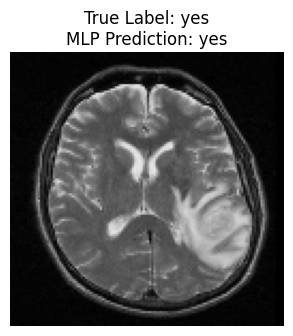

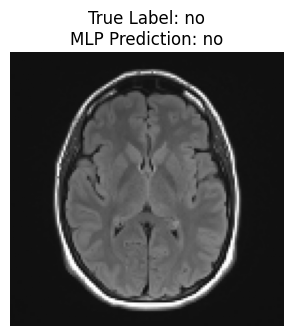

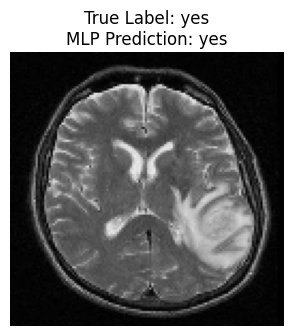

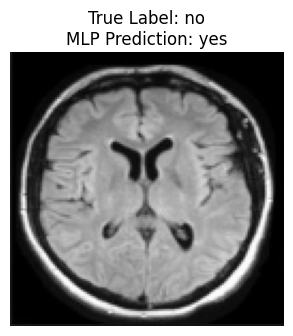

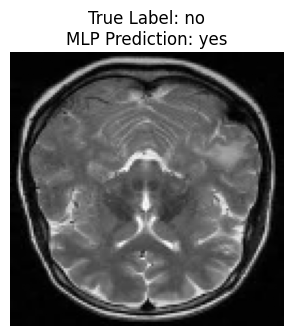

In [102]:
# Get 5 random images

indice = [rd.randint(0, len(test_images)) for i in range(5)]
images = test_images[indice]
labels = test_labels[indice]


class_names = ['no', 'yes']  # 0-9 labels

# Predictions
for i in range(5):
    mlp_pred= MLP_best_model.predict(images[np.newaxis,i])
    if mlp_pred>0.5:
        mlp_final_pred = 1
    else:
        mlp_final_pred = 0
    

    # Create subplots
    plt.figure(figsize=(12, 4))
    # Show the image
    plt.subplot(1, 3, 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"True Label: {class_names[labels[i]]}\nMLP Prediction: {class_names[mlp_final_pred]}")
    plt.axis('off')
    
    

In [103]:
# Construction du modèle CNN

def get_CNN_model():
    model = Sequential([
        Input(shape=(128,128,3), name='input_layer'),
        Conv2D(32, kernel_size=3, activation='relu', name='conv_1'),
        MaxPooling2D(pool_size=(2,2), name='pool_1'),
        Conv2D(64, kernel_size=3, activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(2,2), name='pool_2'),
        Conv2D(128, kernel_size=3, activation='relu', name='conv_3'),
        MaxPooling2D(pool_size=(2,2), name='pool_3'),
        Flatten(name='flatten_layer'),
        Dense(128, activation='relu', name='dense_layer_1'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(1, activation='sigmoid', name='output_layer')
    ])

    return model

In [104]:
# Affichage de l'architecture

CNN_model = get_CNN_model()
CNN_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_1 (Dense)                │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,281 (12.61 MB)

 Trainable params: 3,305,025 (12.61 MB)

 Non-trainable params: 256 (1.00 KB)

In [105]:
# Compilation du modèle

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [106]:
# Création d'une sauvegarde des meilleurs poids

CNN_checkpoint = ModelCheckpoint(filepath='CNN_model_checkpoints_best/checkpoint.weights.h5',
                            save_weights_only = True,
                            save_freq='epoch',
                            monitor='val_acc',
                            save_best_only = True,
                            verbose=1)

In [107]:
# Entraînement du modèle CNN

cnn_history = CNN_model.fit(train_images, 
                    train_labels,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,callbacks=[CNN_checkpoint], verbose=2)

Epoch 1/100

Epoch 1: val_acc improved from -inf to 0.41463, saving model to CNN_model_checkpoints_best/checkpoint.weights.h5
6/6 - 5s - 802ms/step - acc: 0.6894 - loss: 0.6676 - val_acc: 0.4146 - val_loss: 1.1517
Epoch 2/100

Epoch 2: val_acc improved from 0.41463 to 0.51220, saving model to CNN_model_checkpoints_best/checkpoint.weights.h5
6/6 - 0s - 44ms/step - acc: 0.7205 - loss: 0.5802 - val_acc: 0.5122 - val_loss: 0.9487
Epoch 3/100

Epoch 3: val_acc improved from 0.51220 to 0.80488, saving model to CNN_model_checkpoints_best/checkpoint.weights.h5
6/6 - 0s - 42ms/step - acc: 0.7329 - loss: 0.5382 - val_acc: 0.8049 - val_loss: 0.5114
Epoch 4/100

Epoch 4: val_acc did not improve from 0.80488
6/6 - 0s - 26ms/step - acc: 0.7702 - loss: 0.4560 - val_acc: 0.5854 - val_loss: 0.7957
Epoch 5/100

Epoch 5: val_acc did not improve from 0.80488
6/6 - 0s - 24ms/step - acc: 0.8323 - loss: 0.3876 - val_acc: 0.4878 - val_loss: 0.7079
Epoch 6/100

Epoch 6: val_acc improved from 0.80488 to 0.82927

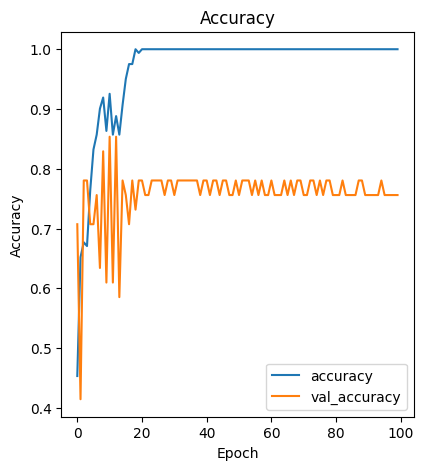

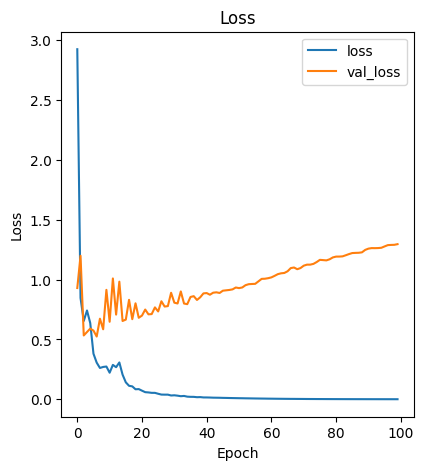

In [109]:
# Affichage de la précision et de la perte

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["acc"], label="accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [110]:
# Evaluation du modèle
test_loss, test_acc = CNN_model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - acc: 0.9269 - loss: 0.3187
Test Loss: 0.32178041338920593
Test Accuracy: 0.9215686321258545


In [111]:
# Evaluation du meilleur modèle

CNN_best_model = get_CNN_model()
CNN_best_model.load_weights('CNN_model_checkpoints_best/checkpoint.weights.h5')
CNN_best_model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['acc'])
best_loss, best_acc = CNN_best_model.evaluate(test_images, test_labels, verbose=False)

print('Loss at best epoch : {}'.format(best_loss))
print('Accuracy at best epoch : {}'.format(best_acc))

Loss at best epoch : 0.2789084017276764
Accuracy at best epoch : 0.9019607901573181


### Comparaison des modèles

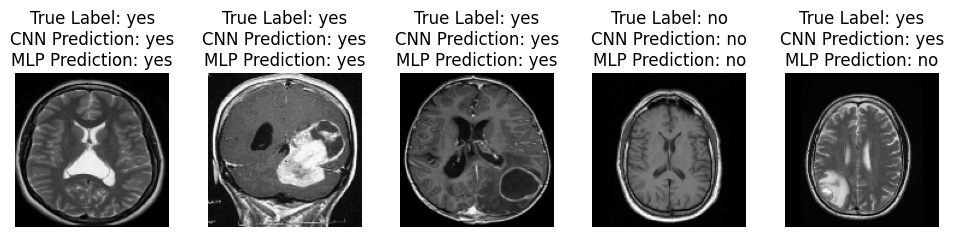

In [131]:
# Get 5 random images

indice = [rd.randint(0, len(test_images)) for i in range(5)]
images = test_images[indice]
labels = test_labels[indice]


class_names = ['no', 'yes']  # 0-9 labels
    
# Create subplots
fig, ax = plt.subplots(1, 5, figsize=(12, 2))
# Show the image
for i in range(5):
    cnn_pred= CNN_best_model.predict(images[np.newaxis,i], verbose=False)
    if cnn_pred>0.5:
        cnn_final_pred = 1
    else:
        cnn_final_pred = 0
    mlp_pred= MLP_best_model.predict(images[np.newaxis,i], verbose=False)
    if mlp_pred>0.5:
        mlp_final_pred = 1
    else:
        mlp_final_pred = 0
        
    ax[i].imshow(images[i])
    ax[i].set_title(f"True Label: {class_names[labels[i]]}\nCNN Prediction: {class_names[cnn_final_pred]}\nMLP Prediction: {class_names[mlp_final_pred]}")
    ax[i].axis('off')

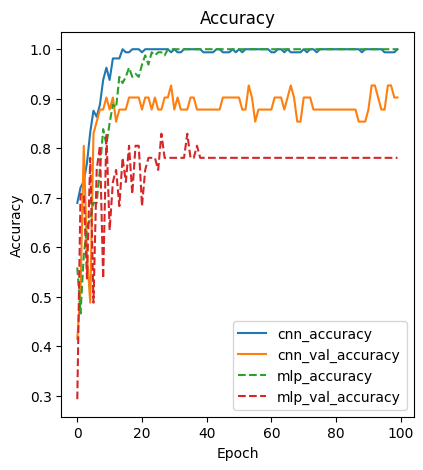

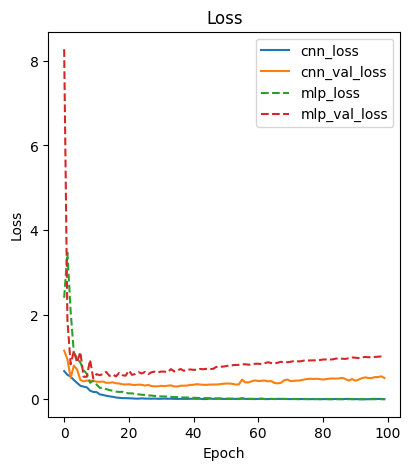

In [115]:
# Comparaison de la précision et de la perte

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history["acc"], label="cnn_accuracy")
plt.plot(cnn_history.history["val_acc"], label="cnn_val_accuracy")
plt.plot(mlp_history.history["acc"], label="mlp_accuracy", linestyle='--')
plt.plot(mlp_history.history["val_acc"], label="mlp_val_accuracy", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history["loss"], label="cnn_loss")
plt.plot(cnn_history.history["val_loss"], label="cnn_val_loss")
plt.plot(mlp_history.history["loss"], label="mlp_loss", linestyle='--')
plt.plot(mlp_history.history["val_loss"], label="mlp_val_loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

### Conclusion 
Les résultats obtenus sont plûtot corrects avec meilleure une précision pour le réseau convolutionnel.